In [ ]:
import os
import pandas as pd
import numpy as np
import h5py
import dask.array as da
from datetime import datetime
import logging

import sys
sys.path.append('../')

from utils.DataPreparation import prepare_data
from utils.DataPreparation import scale_data
from utils.DataGenerator import Generator
from utils.Evaluation import evaluate

import tensorflow as tf
tf.version.VERSION

In [ ]:
# Data directory
hdf5_file = "../Data/datasets.h5" # SET CORRECT PATH TO DATASET FILE

# Coddora model directory
coddora_dir = '../Models/Coddora'

# CoddoraRW model directory
coddoraRW_dir = '../Models/CoddoraRW'

In [9]:
# Datasets for evaluation 
# (note that the meeting room dataset by Stjelja et al. could not be published)

for k in ['Office_A', 'Stjelja']:
    df = pd.read_hdf(hdf5_file, k)
    print("{} ({} days)".format(k, len(df.Day.unique())))

Office_A (80 days)
Stjelja (26 days)


## Define Metadata

In [ ]:
metadata = {
    "Office_A" : {'volume': 77.5,  'infiltration': 0.0001,   'occupants':  2},
    "Home" :     {'volume':   40,  'infiltration': 0.0001,   'occupants':  2},
    "Stjelja" :  {'volume': 73.5,  'infiltration': 0.0001,   'occupants': 12},
} 

def scale_meta_features(meta_features):
    '''
    :param meta_features: feature array [_volume, infiltration, maxOccupants]
    '''
    meta_features[0] = scale_data(meta_features[0], min_domain=9.6, max_domain=400)
    meta_features[1] = scale_data(meta_features[1], min_domain=0.000085, max_domain=0.00085)
    meta_features[2] = scale_data(meta_features[2], min_domain=1, max_domain=12)
    return meta_features

## Sample Data Function

In [ ]:
def sample_data(k, days, add_metadata=False):
    
    df = pd.read_hdf(hdf5_file, k)
    training_data = df[df.Day.isin(df.Day.unique()[:days])]
    val_data     = df[~df.Day.isin(df.Day.unique()[:days])]
    print(len(training_data), len(val_data))

    x_train, y_train = prepare_data(training_data['CO2'].values, training_data['Occupancy'].values, 
                                  window_size=30, normalize='CO2', verbose=0)
    x_val, y_val = prepare_data(val_data['CO2'].values, val_data['Occupancy'].values, 
                                  window_size=30, normalize='CO2', verbose=0)
    if add_metadata:
        meta_features = scale_meta_features(list(metadata[k].values()))
        x_train_meta = np.array([meta_features for d in range(0, len(x_train))])
        x_val_meta = np.array([meta_features for d in range(0, len(x_val))])
        print("train", np.shape(x_train), np.shape(x_train_meta), np.shape(y_train))
        print("val ", np.shape(x_val), np.shape(x_val_meta), np.shape(y_val))
        data = {'x_train': [x_train, x_train_meta], 
                'y_train': y_train,
                'x_val': [x_val, x_val_meta],
                'y_val': y_val}
    else:
        print("train", np.shape(x_train), np.shape(y_train))
        print("val ", np.shape(x_val), np.shape(y_val))
        data = {'x_train': x_train, 'y_train': y_train, 'x_val': x_val, 'y_val': y_val}

    return data

## Load Models

In [ ]:
coddora   = tf.keras.models.load_model(coddora_dir)
coddoraRW = tf.keras.models.load_model(coddoraRW_dir)

## Zero-Shot Evaluation (CoddoraRW)

In [11]:
# load office data
data_office = sample_data('Office_A', 60, add_metadata=True)

86400 28800
train (86368, 30, 1) (86368, 3) (86368, 1)
val  (28768, 30, 1) (28768, 3) (28768, 1)


In [12]:
print("expected accuracy:", 1 - data_office['y_val'].mean())

expected accuracy: 0.6491240266963292


In [13]:
# load meeting room data
data_meeting = sample_data('Stjelja', 6, add_metadata=True)

8640 28798
train (8608, 30, 1) (8608, 3) (8608, 1)
val  (28768, 30, 1) (28768, 3) (28768, 1)


In [14]:
print("expected accuracy:", 1 - data_meeting['y_val'].mean())

expected accuracy: 0.906110956618465


DescribeResult(nobs=28768, minmax=(0, 1), mean=0.34187291434927697, variance=0.2250036461005618, skewness=0.666728520002772, kurtosis=-1.555473080614913) 



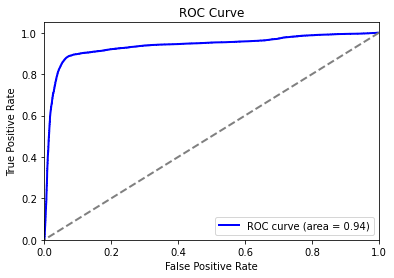

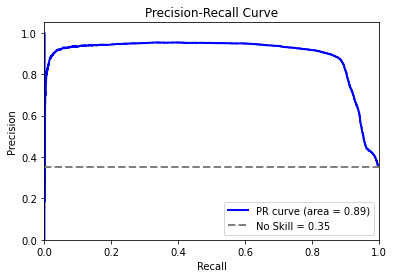

{'Accuracy': 0.91494021134594,
 'Balanced Accuracy': 0.9036879242796836,
 'F1-Score': 0.8772141100908224,
 'Precision': 0.8887646161667514,
 'Recall': 0.8659599762234991,
 'Matthews Correlation Coefficient': 0.8123238078381211,
 'Cohens Kappa': 0.8121632487717244,
 'ROC-AUC': 0.9352785195408209,
 'PR-AUC': 0.8945112548991315,
 'Loss': 0.27096793}

In [17]:
# evaluate on office data
evaluate(coddoraRW, data_office['x_val'], data_office['y_val'], batch_size=128, verbose=1)

DescribeResult(nobs=28768, minmax=(0, 1), mean=0.01658092324805339, variance=0.016306563062212905, skewness=7.571468353123746, kurtosis=55.3271330223544) 



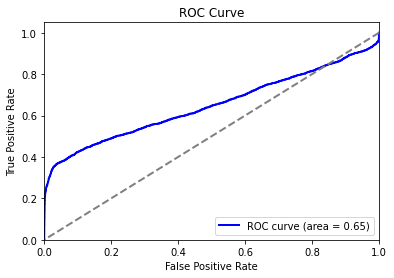

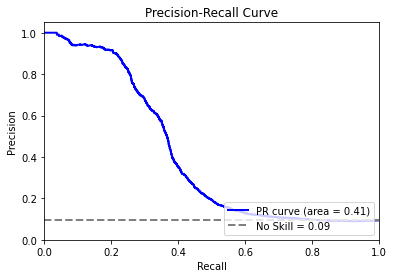

{'Accuracy': 0.9204671857619577,
 'Balanced Accuracy': 0.5817630945528445,
 'F1-Score': 0.28005034612964125,
 'Precision': 0.9329140461215933,
 'Recall': 0.16475379489078118,
 'Matthews Correlation Coefficient': 0.37351822322356487,
 'Cohens Kappa': 0.25917048170498025,
 'ROC-AUC': 0.6478174667004191,
 'PR-AUC': 0.407400459977796,
 'Loss': 0.27412784}

In [19]:
# evaluate on meeting room data
evaluate(coddoraRW, data_meeting['x_val'], data_meeting['y_val'], batch_size=128, verbose=1)

## Zero-Shot Evaluation with simulation-based model (Coddora)

DescribeResult(nobs=28768, minmax=(0, 1), mean=0.7291087319243604, variance=0.1975160547810526, skewness=-1.031045864012097, kurtosis=-0.936944426303548) 



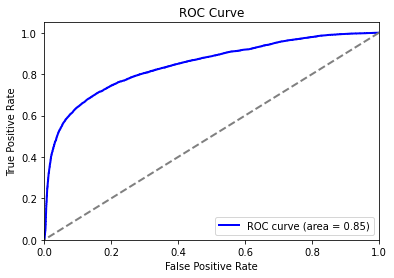

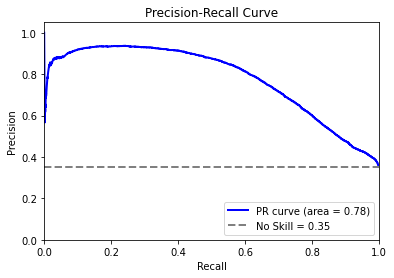

{'Accuracy': 0.5690002780867631,
 'Balanced Accuracy': 0.6507401328232193,
 'F1-Score': 0.6009205317197206,
 'Precision': 0.44505363528009534,
 'Recall': 0.9248068159302556,
 'Matthews Correlation Coefficient': 0.32374710519741356,
 'Cohens Kappa': 0.24163991586072953,
 'ROC-AUC': 0.8452015549921559,
 'PR-AUC': 0.7781256180146364,
 'Loss': 0.8810993}

In [28]:
# evaluate on office data
evaluate(coddora, data_office['x_val'], data_office['y_val'], batch_size=128, verbose=1)

DescribeResult(nobs=28768, minmax=(0, 1), mean=0.7057146829810901, variance=0.20768868864038342, skewness=-0.9028101076665614, kurtosis=-1.1849339094950917) 



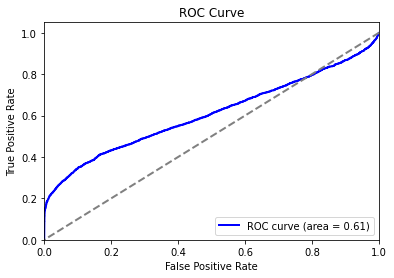

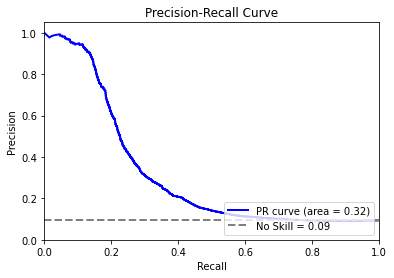

{'Accuracy': 0.3383273081201335,
 'Balanced Accuracy': 0.5159075876681352,
 'F1-Score': 0.17249923922966567,
 'Precision': 0.09772436213180967,
 'Recall': 0.7345427619400222,
 'Matthews Correlation Coefficient': 0.020362617121330875,
 'Cohens Kappa': 0.008114818371069754,
 'ROC-AUC': 0.607327858619446,
 'PR-AUC': 0.31700767332658203,
 'Loss': 1.0397741}

In [29]:
# evaluate on meeting room data
evaluate(coddora, data_meeting['x_val'], data_meeting['y_val'], batch_size=128, verbose=1)